In [53]:
import numpy as np
import scipy.constants as const
import uncertainties as unc
import uncertainties.unumpy as up
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from lmfit.models import LinearModel

In [70]:
Na = pd.read_csv('./Data/Na_Dlines_calibration_140hz.csv')

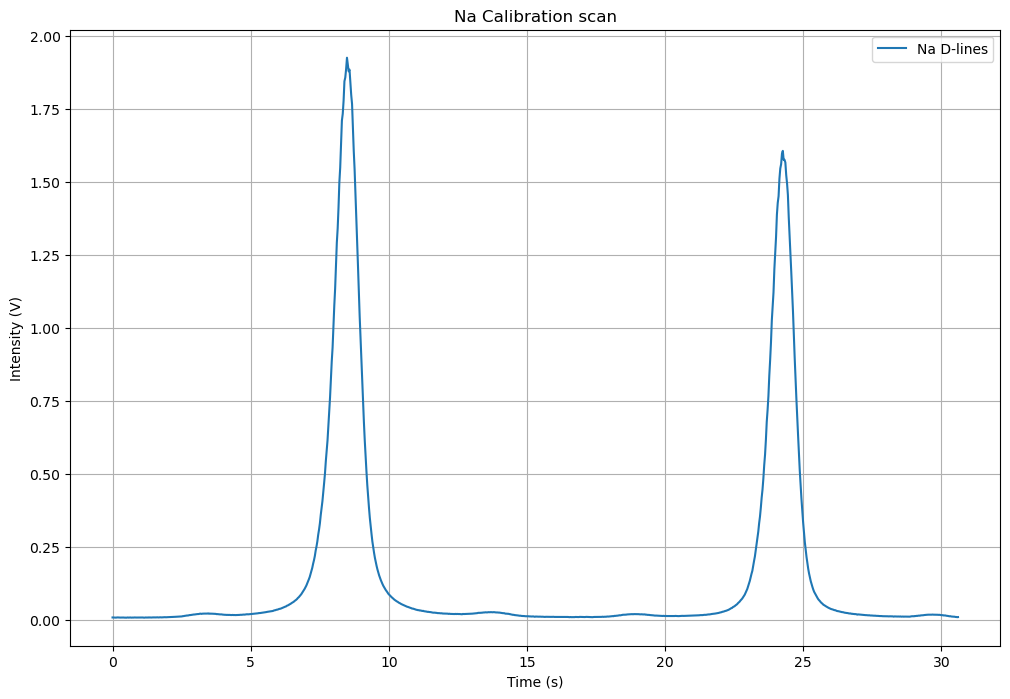

In [19]:
plt.figure(figsize=(12,8))
plt.grid()
plt.title('Na Calibration scan')
plt.ylabel(r'Intensity (V)')
plt.xlabel(r'Time (s)')
plt.plot(Na['X'], Na[' Y0'],'-',label='Na D-lines')
plt.legend();

In [36]:
Na['CH1_smoothed'] = gaussian_filter1d(Na[' Y0'], 2)

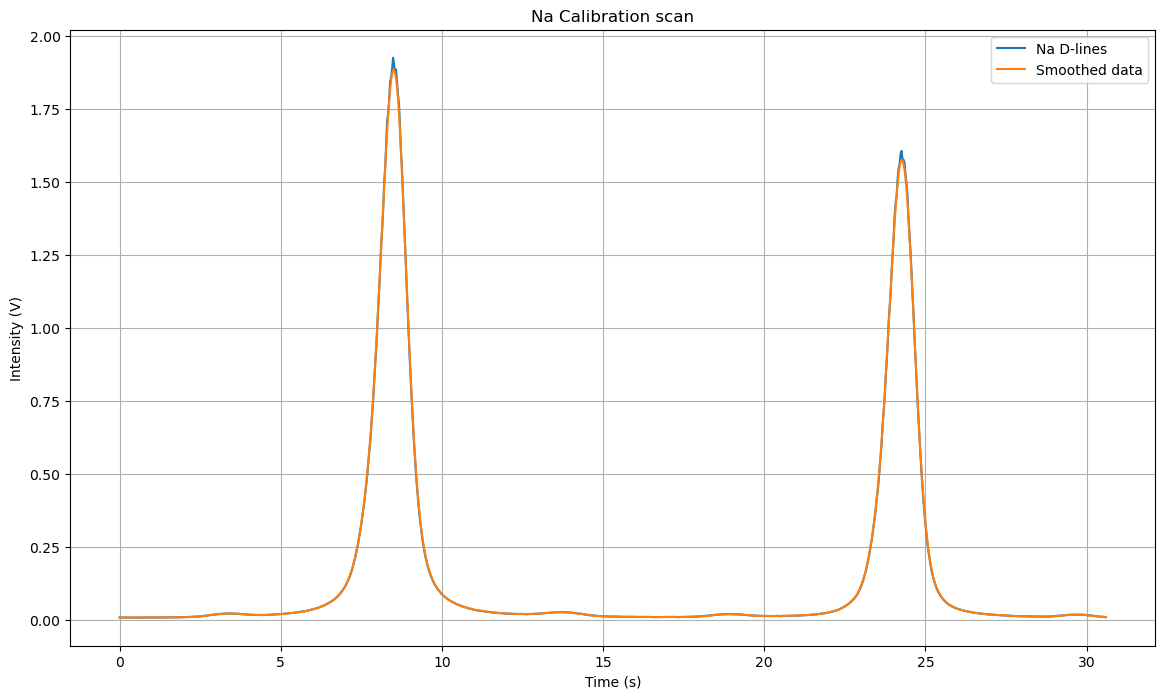

In [56]:
plt.figure(figsize=(14,8))
plt.grid()
plt.title('Na Calibration scan')
plt.ylabel(r'Intensity (V)')
plt.xlabel(r'Time (s)')
plt.plot(Na['X'], Na[' Y0'],'-',label='Na D-lines')
plt.plot(Na['X'], Na['CH1_smoothed'],'-',label='Smoothed data')
plt.legend();

In [47]:
# assign current arrays to xdata, ydata
ydata = Na['CH1_smoothed']
xdata = Na['X']

# A "min width" keeps small fluctuations near the top from being labeled separate peaks
# Width units are array indices
min_width = 25

# Below does the work.  The height parameter makes the function only look 
# for peaks higher than halfway up the tallest peak.
peaks, pk_props = find_peaks(ydata, width = min_width, height = ydata.max()/2.)

for pk, prop in zip(peaks, pk_props['widths']): 
    print('Peak at {:d} has width {:.1f}'.format(pk, prop))


Peak at 278 has width 33.3
Peak at 792 has width 32.4


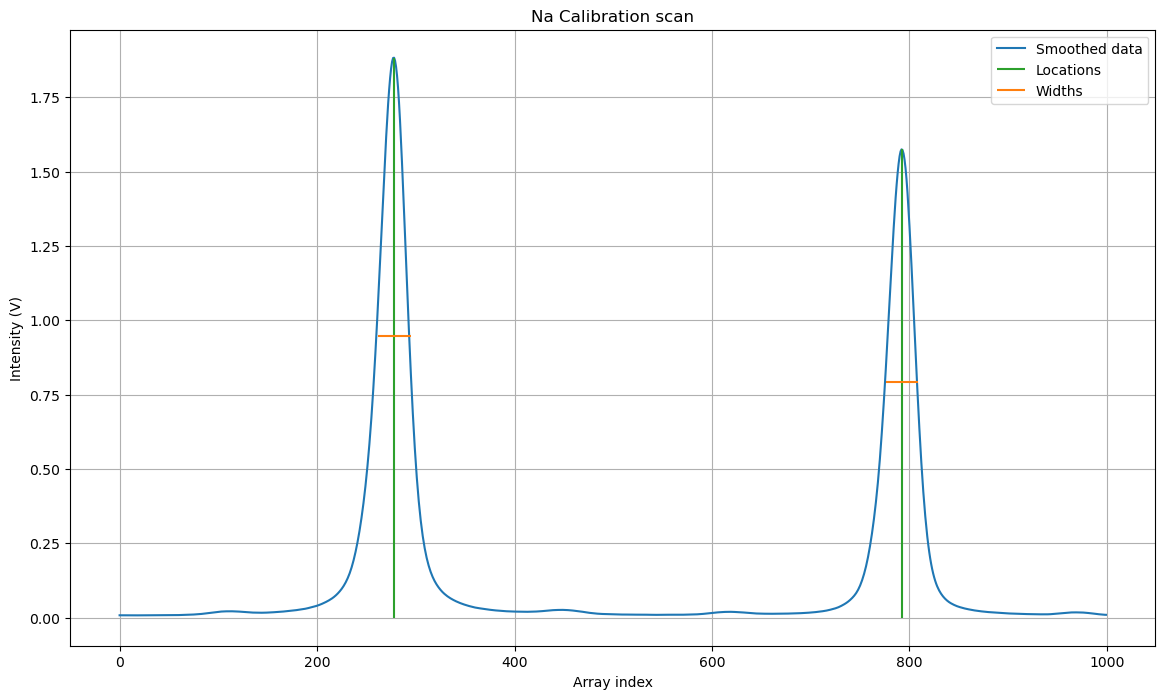

In [58]:
plt.figure(figsize=(14,8))
plt.grid()
plt.title('Na Calibration scan')
plt.ylabel(r'Intensity (V)')
plt.xlabel(r'Array index')
plt.plot(ydata,'-',label='Smoothed data')
plt.vlines(x=peaks, ymin=0, ymax=ydata[peaks], color='C2', label='Locations')
plt.hlines(y=pk_props['width_heights'], xmin=peaks-pk_props['widths']/2, 
           xmax=peaks+pk_props['widths']/2, color = 'C1', label='Widths')
plt.legend();

In [49]:
xpeaks = np.array([xdata[peaks[0]], xdata[peaks[1]]])
xpeaks

array([ 8.515 , 24.2587])

In [50]:
idx2time = (xdata[peaks[1]]-xdata[peaks[0]])/(peaks[1]-peaks[0])
xwidths = pk_props['widths']*idx2time
xwidths

array([1.01931605, 0.99163941])

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 1000
    # variables        = 2
    chi-square         = 131.423440
    reduced chi-square = 0.13168681
    Akaike info crit   = -2025.33080
    Bayesian info crit = -2015.51529
    R-squared          = 2.2939e-06
[[Variables]]
    slope:      6.2098e-05 +/- 0.00129784 (2089.98%) (init = 6.209805e-05)
    intercept:  0.14715533 +/- 0.02293377 (15.58%) (init = 0.1471553)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.866

Slope =  6.209804584538482e-05 +/- 0.0012978373145261688


<Figure size 1400x800 with 0 Axes>

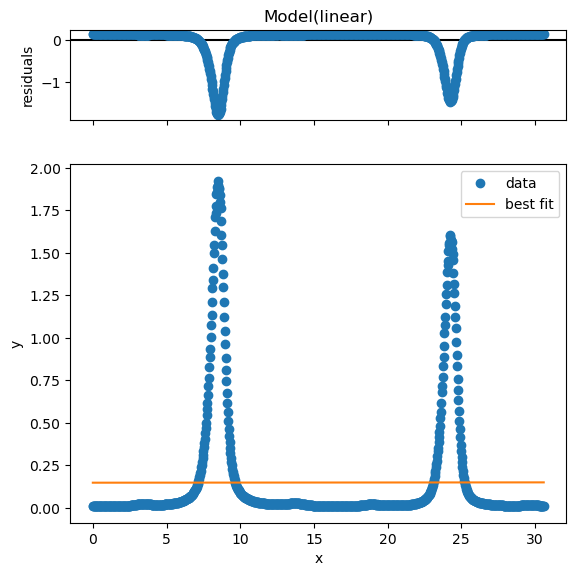

In [61]:
# create an instance of the model
line = LinearModel()

# One must have a guess of the parameters. The guess() method works with most of the standard
# lmfit models
param_guess = line.guess(Na[' Y0'], x = Na['X'])

# The line below executes the fitting process.  The results are returned to "line_fit"
line_fit = line.fit(Na[' Y0'], param_guess, x = Na['X'])

# This prints the results in an easy to read form
print(line_fit.fit_report())

# The parameters and uncertainties are accessible as follows, for example:
print('\nSlope = ',line_fit.params['slope'].value,'+/-',line_fit.params['slope'].stderr)

#Then you can plot the results quickly just to see how it looks using the plot() method
line_fit.plot();

In [62]:
from lmfit.models import ConstantModel, GaussianModel

# create an instance of the model
# Note the use of prefixes
model = ConstantModel() + GaussianModel(prefix='p1_') + GaussianModel(prefix='p2_')

# Necessary step below.  This replaces the guess() method used earlier.  The guess() method 
# does not work for composite models.
params = model.make_params()

# Notice how the prefixes are attached to the parameter names.
print('parameter names: {}'.format(model.param_names))

parameter names: ['c', 'p1_amplitude', 'p1_center', 'p1_sigma', 'p2_amplitude', 'p2_center', 'p2_sigma']


In [63]:
# Peak 1 starting values

p1_loc = xpeaks[0]
p1_sig = xwidths[0]/2.3548
p1_amp = ydata[peaks[0]]*xwidths[0]

# Peak 2 starting values

p2_loc = xpeaks[1]
p2_sig = xwidths[1]/2.3548
p2_amp = ydata[peaks[1]]*xwidths[0]

# Build the parameters

params['p1_center'].set(value=p1_loc, vary=True)
params['p1_amplitude'].set(value=p1_amp, vary=True)
params['p1_sigma'].set(value=p1_sig, vary=True)

params['p2_center'].set(value=p2_loc, vary=True)
params['p2_amplitude'].set(value=p2_amp, vary=True)
params['p2_sigma'].set(value=p2_sig, vary=True)

params['c'].set(value = 0.01, vary=True)

params.pretty_print(columns=['value','vary'])

Name             Value     Vary
c                 0.01     True
p1_amplitude     1.919     True
p1_center        8.515     True
p1_fwhm          1.019    False
p1_height        1.769    False
p1_sigma        0.4329     True
p2_amplitude     1.605     True
p2_center        24.26     True
p2_fwhm         0.9916    False
p2_height        1.521    False
p2_sigma        0.4211     True


[[Model]]
    ((Model(constant) + Model(gaussian, prefix='p1_')) + Model(gaussian, prefix='p2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 1000
    # variables        = 7
    chi-square         = 0.77880527
    reduced chi-square = 7.8430e-04
    Akaike info crit   = -7143.74952
    Bayesian info crit = -7109.39524
    R-squared          = 0.99401150
[[Variables]]
    c:             0.02532887 +/- 9.6497e-04 (3.81%) (init = 0.01)
    p1_amplitude:  2.09295270 +/- 0.00809432 (0.39%) (init = 1.919141)
    p1_center:     8.47173689 +/- 0.00199513 (0.02%) (init = 8.515)
    p1_sigma:      0.46781207 +/- 0.00202694 (0.43%) (init = 0.4328674)
    p2_amplitude:  1.66764689 +/- 0.00783713 (0.47%) (init = 1.605244)
    p2_center:     24.2393513 +/- 0.00229019 (0.01%) (init = 24.2587)
    p2_sigma:      0.44079056 +/- 0.00232462 (0.53%) (init = 0.4211141)
    p1_fwhm:       1.10161321 +/- 0.00477308 (0.43%) == '2.3548200*p1_sigma'
 

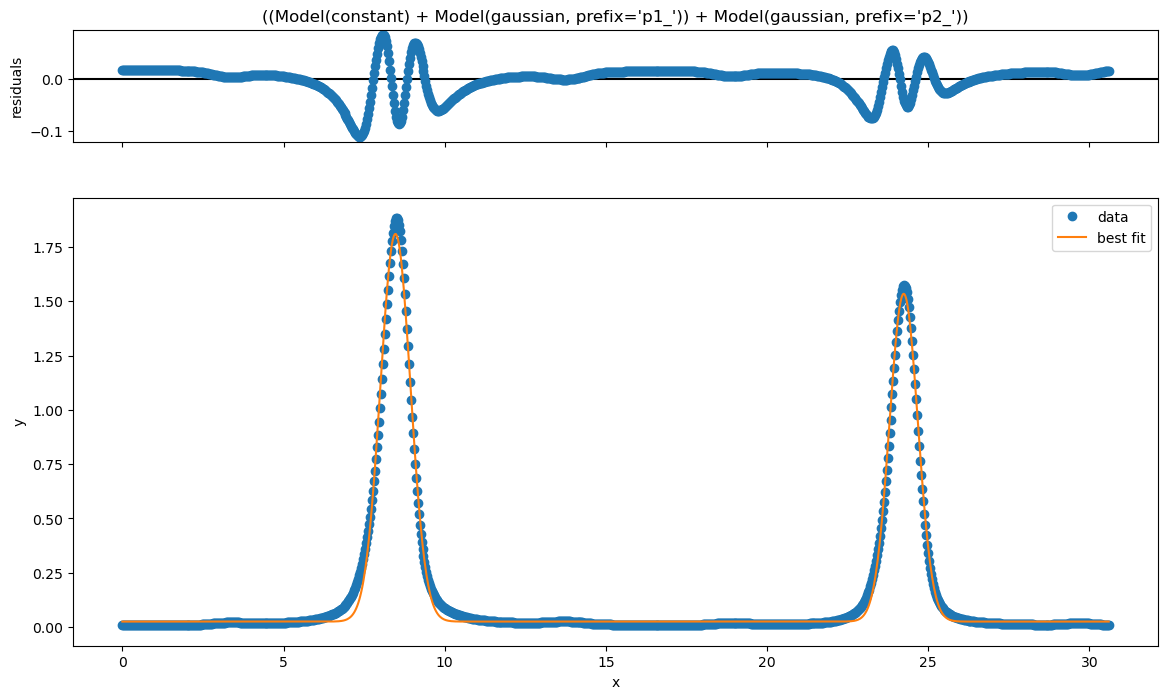

In [68]:
model_fit = model.fit(ydata, params, x=xdata)

print(model_fit.fit_report(show_correl=False))

myfig=plt.figure(figsize=(14,8))
model_fit.plot(fig=myfig);

In [65]:
Peak_loc = []

for parm in model_fit.params:
    if parm.endswith('center'):
        # make an uncertainty object
        this_center = unc.ufloat(model_fit.params[parm].value, model_fit.params[parm].stderr)
        # add it to the Python list
        Peak_loc.append(this_center)
        # also print it
        print('Peak at {:.2uP} s'.format(this_center))

# Save the list to a new variable 
Na_loc = Peak_loc.copy()

Peak at 8.4717±0.0020 s
Peak at 24.2394±0.0023 s


In [66]:
D1 = 5895.92 # Angstroms
D2 = 5889.95 # Angstroms

Na_cal = (D1-D2)/(Na_loc[1]-Na_loc[0])

print('Calibration constant from peak-fit method: {:.2uP} A/s'.format(Na_cal))

Calibration constant from peak-fit method: 0.378624±0.000073 A/s


In [74]:
Alpha = pd.read_csv('./Data/H-D alpha lines 140 hz.csv')
Beta = pd.read_csv('./Data/H-D beta lines 140 hz.csv')
Gamma = pd.read_csv('./Data/H-D gamma lines 140 hz.csv')
Delta = pd.read_csv('./Data/H-D  delta lines 140 hz.csv')

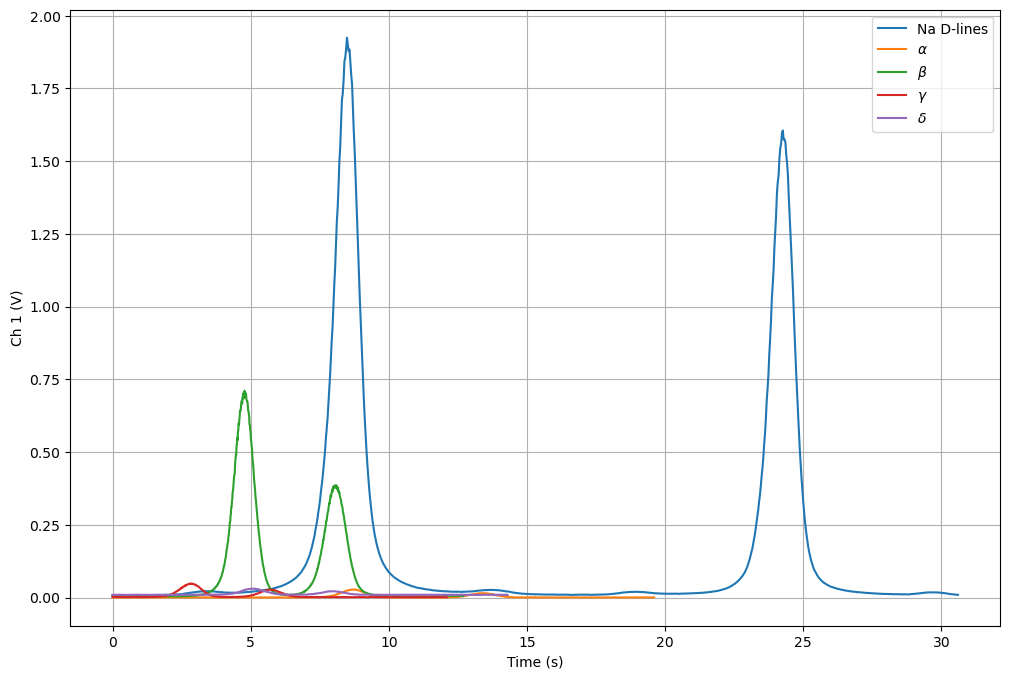

In [75]:
plt.figure(figsize=(12,8))
plt.plot(Na['X'], Na[' Y0'],'-',label='Na D-lines')
plt.plot(Alpha['X'], Alpha[' Y0'],'-',label=r'$\alpha$')
plt.plot(Beta['X'], Beta[' Y0'],'-',label=r'$\beta$')
plt.plot(Gamma['X'], Gamma[' Y0'],'-',label=r'$\gamma$')
plt.plot(Delta['X'], Delta[' Y0'],'-',label=r'$\delta$')
plt.xlabel(r'Time (s)')
plt.ylabel(r'Ch 1 (V)')
plt.legend()
plt.grid();

In [76]:
## Function to locate the peaks, plot them, and return the important data

def find_and_plot_peaks(data, title='Data', makeplot=True):
    '''
    Function locates peaks using SciPy.signal find_peaks() and plots
    the results (optionally).  Returns two arrays: 'peaks' which holds
    the index of each peak maximum and 'widths' which holds the FWHM of
    each peak.
    '''
    data['CH1_smoothed'] = gaussian_filter1d(data[' Y0'], 2)
    ydata = data['CH1_smoothed']
    xdata = data['X']

    min_width = 25

    peaks, pk_props = find_peaks(ydata, width = min_width, height = ydata.max()/2.)

    # for pk, prop in zip(peaks, pk_props['widths']): 
    #     print('Peak at {:d} has width {:.1f}'.format(pk, prop)) 
        
    return peaks, pk_props['widths']

In [77]:
## Function to obtain starting values for fit
def guess_start_parms(xdata, ydata, peaks, widths, params):
    '''
    Calculates starting values for the peak fitting routine.  
    Returns params object
    '''
    # You fill in the rest
    
    return params

In [ ]:
def calculate_peak_locs(xdata, ydata, params):
    '''
    Fit data to two gaussian peaks and extract peak positions.
    Plots result and extracts centers with uncertainty.
    Returns a list of uncertainty objects
    '''
    
    return Peak_loc
